# OFAT SA

In [ ]:
%matplotlib inline
from model import *
from agents import *
from globals import *
from server import *
from schedule import *
from utility import *
from SALib.sample import saltelli
from mesa.batchrunner import BatchRunner, BatchRunnerMP
from SALib.analyze import sobol
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from itertools import combinations
from IPython.display import clear_output
import multiprocessing as mp

In [ ]:
fixed_params = {
    "N": 1000,
    "network_type": 2,
    "no_of_neighbors": 3,
    "beta_component": 0.15,
    "social_influence": 0.06,
    "swingers": 3,
    "malicious_N":0,
    "echo_limit": .95,
    "all_majority": False,
    "opinions":2,
    
}
 

variable_params = {
        "opinions":range(2, 6),
    #"N": range(100, 20, 50),
#     "no_of_neighbors": range(2, 4),
#     "beta_component": np.arange(0.0, 1.0, 0.2),
#     "similarity_treshold": np.arange(0.01, 0.11, 0.02),
#     "social_influence": np.arange(0.01, 0.11, 0.02),
#     "swingers": range(1, 5),
#     "echo_threshold": np.arange(0.05,0.21,0.01),
#     "opinions": range(2,6)
}

# print(variable_params['echo_threshold'])

# Set the repetitions, the amount of steps, and the amount of distinct values per variable
replicates = 30
max_steps = 100

# Set the outputs
model_reporters = {
#                 "preferences": compute_preferences,
#                 "opinions": compute_opinions,
#                 "preference_A": compute_preference_A,
#                 "preference_B": compute_preference_B,
                "radical_opinions": compute_radical_opinions,
                "community_no": community_no,
                "echo_chambers": echo_no,
                "majority_opinion": compute_majority_opinions,
                "silent_spiral": compute_silent_spiral,
                "compute_transitivity":compute_transitivity
}

data = {}

  
batch = BatchRunnerMP(Network, 
                    max_steps=max_steps,
                    iterations=replicates,
                    fixed_parameters=fixed_params,
                    variable_parameters=variable_params,
                    model_reporters=model_reporters, 
                    nr_processes=4,
                    display_progress=True)
    
batch.run_all()
data = batch.get_model_vars_dataframe()

#print data
print(data)


In [ ]:
data.to_pickle('./Data/OFAT_NWsize.pkl')

In [ ]:
# f, axarr = plt.subplots(8, sharex=True, dpi=500)

for i in range(1,len(list(data))):
    plt.figure(dpi=100)
    plt.scatter(data.iloc[:,0],data.iloc[:,i], alpha=.2)
    plt.xlabel('opinions')
    plt.ylabel(list(data)[i])
#     plt.ylim([-0.1,1.1])
    plt.show()

In [ ]:
global_average = np.mean(data['echo_chambers'])
avarages = []
for i in np.arange(0.05,0.21,0.01):
    avarage = np.mean(data['echo_chambers'].where(data['echo_threshold'] == i))
    avarages.append(avarage)

print(avarages)
print(global_average)

In [ ]:
# for i in range(len(list(data))):
plt.boxplot(data["echo_chambers"],[i for i in data[list(data)[i]]])
plt.title(list(data)[i])
plt.xlabel('N')
plt.ylabel(list(data)[i])
plt.show()


In [ ]:
list(data)

In [ ]:
# Example plots for varying beta component

replicates = 5
distinct_samples = 5

beta_component = np.arange(0.0, 1.0, 0.2)

# community number
count=0
list_mean_community_no = []
list_err_community_no = []
for i in range(distinct_samples):
    community_no = []
    for j in range(replicates):
        community_no.append(data.community_no[count + j])
    count = count + j + 1
    mean = np.mean(community_no)
    std = np.std(community_no)
    err = 1.96 * std / np.sqrt(replicates)
    list_mean_community_no.append(mean)
    list_err_community_no.append(err)

# radical opinions
count=0
list_mean_radical_opinions = []
list_err_radical_opinions = []
for i in range(distinct_samples):
    radical_opinions = []
    for j in range(replicates):
        radical_opinions.append(data.radical_opinions[count + j])
    count = count + j + 1
    mean = np.mean(radical_opinions)
    std = np.std(radical_opinions)
    err = 1.96 * std / np.sqrt(replicates)
    list_mean_radical_opinions.append(mean)
    list_err_radical_opinions.append(err)


ax1 = plt.subplot(211, xticklabels=[])
plt.errorbar(beta_component, list_mean_community_no, yerr=list_err_community_no, marker='s', linestyle='None')
plt.ylabel('community number')

ax2 = plt.subplot(212, sharex = ax1)
plt.errorbar(beta_component, list_mean_radical_opinions, yerr=list_err_radical_opinions, marker='s', linestyle='None')
plt.xlabel('beta component')
plt.ylabel('radical opinions')

plt.subplots_adjust(hspace=.0)
plt.show()

# Sobol SA

In [9]:
#### %matplotlib inline
from model import *
from agents import *
from globals import *
# from server import *
from schedule import *
from utility import *
from SALib.sample import saltelli
from mesa.batchrunner import BatchRunner, BatchRunnerMP
import pathos
from SALib.analyze import sobol
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from itertools import combinations
from IPython.display import clear_output
import time
import multiprocessing as mp
import analysis



In [10]:
# We define our variables and bounds

fixed_params = {
    "network_type": 2
}

problem = {
    'num_vars':6,
    'names': ['similarity_treshold', 'social_influence', 'swingers', 'no_of_neighbors', 'echo_limit',"opinions"],
    'bounds': [[0.01,0.1], [0.01, 0.1], [1, 5], [2,6], [0.80,0.95], [2,5]]
}

# Set the repetitions, the amount of steps, and the amount of distinct values per variable
replicates = 30
max_steps = 100
distinct_samples = 10

# We get all our samples here
param_values = saltelli.sample(problem, distinct_samples, calc_second_order= False)


In [11]:


# DIRK ZIJN DISTINCT SAMPLES
DIRK = param_values[len(param_values)//2:]

#TOBIAS ZIJN DISTINCT SAMPLES
# TOBIAS = param_values[:len(param_values)//2]


In [ ]:
# Set the outputs
model_reporters = {
#                 "preferences": compute_preferences,
#                 "opinions": compute_opinions,
#                 "preference_A": compute_preference_A,
#                 "preference_B": compute_preference_B,
                "radical_opinions": compute_radical_opinions,
                "Silent_Spiral": compute_silent_spiral,
                "majority_percentage": compute_majority_opinions,
                "community_no": community_no,
                "transitivity": compute_transitivity,
                "echo_chamber": compute_echo_chamber,
                "echo_size": echochamber_size,
                "echo_count": echochamber_count,          
}

param_values = DIRK
# param_values = TOBIAS

# BatchRunner
batch = BatchRunnerMP(Network, 
                    max_steps=max_steps,
                    fixed_parameters=fixed_params,
                    variable_parameters={name:[] for name in problem['names']},
                    model_reporters=model_reporters, nr_processes=8)
times = []
count = 0
for i in range(replicates):
    for vals in param_values:
        start = time.time()
        # Change parameters that should be integers
        vals = list(vals)
#         vals[2] = int(vals[2])

        # Transform to dict with parameter names and their values
        variable_parameters = {}
        for name, val in zip(problem['names'], vals):
            variable_parameters[name] = val
        variable_parameters['network_type']=2
        variable_parameters['malicious_N']=0
        variable_parameters['N']=1000
        variable_parameters['beta_component']=1
        variable_parameters['swingers']=int(variable_parameters['swingers'])
        variable_parameters['no_of_neighbors']=int(variable_parameters['no_of_neighbors'])
        variable_parameters['all_majority']=False
        variable_parameters['opinions']=int(variable_parameters['opinions'])

        batch.run_iteration(variable_parameters, tuple(vals), count)
        count += 1

        clear_output()
        print(f'{count / (len(param_values) * (replicates)) * 100:.2f}% done')
        times.append(time.time() - start)
        meantime = np.mean(times)
        print('Average duration per iteration: %s seconds.'%str(meantime))
        nectime = ((len(param_values) * (replicates))-count)*meantime
        print('Expected time till finish: ', int(nectime/3600), 'hours and ', int((nectime%3600)/60), ' minutes.')
        
        
    
data = batch.get_model_vars_dataframe()
data.to_pickle('./Data/Dirk_Sobol_BA.pkl')


In [ ]:
print(data)

In [ ]:
# data.to_pickle()
pickle.dump(data, './Data/Dirk_Sobol_BA_2.pkl')
# data = pd.read_pickle('data.pkl')

In [7]:
def plot_index(s, params, i, title=''):
    """
    Creates a plot for Sobol sensitivity analysis that shows the contributions
    of each parameter to the global sensitivity.

    Args:
        s (dict): dictionary {'S#': dict, 'S#_conf': dict} of dicts that hold
            the values for a set of parameters
        params (list): the parameters taken from s
        i (str): string that indicates what order the sensitivity is.
        title (str): title for the plot
    """

    if i == '2':
        p = len(params)
        params = list(combinations(params, 2))
        indices = s['S' + i].reshape((p ** 2))
        indices = indices[~np.isnan(indices)]
        errors = s['S' + i + '_conf'].reshape((p ** 2))
        errors = errors[~np.isnan(errors)]
    else:
        indices = s['S' + i]
        errors = s['S' + i + '_conf']
        plt.figure()

    l = len(indices)

    plt.title(title)
    plt.ylim([-0.2, len(indices) - 1 + 0.2])
    plt.yticks(range(l), params)
    plt.errorbar(indices, range(l), xerr=errors, linestyle='None', marker='o')
    plt.axvline(0, c='k')
    
for Si in ("opinions", "radical_opinions"):
    # First order
    plot_index(Si, problem['names'], '1', 'First order sensitivity')
    plt.savefig('a')
    plt.show()

    # Second order
#     plot_index(Si, problem['names'], '2', 'Second order sensitivity')
#     plt.show()

    # Total order
    plot_index(Si, problem['names'], 'T', 'Total order sensitivity')
    plt.show()

NameError: name 'problem' is not defined

In [5]:
import _pickle as cPickle
import pandas as pd

print(np.__version__)
print(pd.__version__)

path_pickle = './Data/Dirk_Sobol_BA.pkl'

with open(path_pickle, 'rb') as fo:
    data = cPickle.load(fo, encoding='latin1')
                            
D_data = data


1.16.1
0.22.0


In [2]:
print(D_data)

      similarity_treshold  social_influence  swingers  no_of_neighbors  \
0                0.086025          0.097451  3.574219         5.207031   
1                0.092881          0.097451  3.574219         5.207031   
2                0.086025          0.057197  3.574219         5.207031   
3                0.086025          0.097451  4.503906         5.207031   
4                0.086025          0.097451  3.574219         2.777344   
5                0.086025          0.097451  3.574219         5.207031   
6                0.086025          0.097451  3.574219         5.207031   
7                0.092881          0.057197  4.503906         2.777344   
8                0.063525          0.029951  2.574219         2.207031   
9                0.025381          0.029951  2.574219         2.207031   
10               0.063525          0.079697  2.574219         2.207031   
11               0.063525          0.029951  3.503906         2.207031   
12               0.063525          0.0

In [17]:
def plot_index(s, params, i, title=''):
    """
    Creates a plot for Sobol sensitivity analysis that shows the contributions
    of each parameter to the global sensitivity.

    Args:
        s (dict): dictionary {'S#': dict, 'S#_conf': dict} of dicts that hold
            the values for a set of parameters
        params (list): the parameters taken from s
        i (str): string that indicates what order the sensitivity is.
        title (str): title for the plot
    """

    if i == '2':
        p = len(params)
        params = list(combinations(params, 2))
        indices = s['S' + i].reshape((p ** 2))
        indices = indices[~np.isnan(indices)]
        errors = s['S' + i + '_conf'].reshape((p ** 2))
        errors = errors[~np.isnan(errors)]
    else:
        indices = s['S' + i]
        errors = s['S' + i + '_conf']
        plt.figure()

    l = len(indices)

    plt.title(title)
    plt.ylim([-0.2, len(indices) - 1 + 0.2])
    plt.yticks(range(l), params)
    plt.errorbar(indices, range(l), xerr=errors, linestyle='None', marker='o')
    plt.axvline(0, c='k')


In [20]:
echo_count = sobol.analyze(problem, data['echo_count'].as_matrix(), print_to_console=True, calc_second_order=False)      
Silent_Spiral = sobol.analyze(problem, data['Silent_Spiral'].as_matrix(), print_to_console=True, calc_second_order=False)      
community_no = sobol.analyze(problem, data['community_no'].as_matrix(), print_to_console=True, calc_second_order=False)      
echo_chamber = sobol.analyze(problem, data['echo_chamber'].as_matrix(), print_to_console=True, calc_second_order=False)      
majority_percentage = sobol.analyze(problem, data['majority_percentage'].as_matrix(), print_to_console=True, calc_second_order=False)      
radical_opinions = sobol.analyze(problem, data['radical_opinions'].as_matrix(), print_to_console=True, calc_second_order=False)      
transitivity = sobol.analyze(problem, data['transitivity'].as_matrix(), print_to_console=True, calc_second_order=False)      


to_plot = [majority_percentage,echo_count,Silent_Spiral,community_no,echo_chamber,radical_opinions,transitivity]

Parameter S1 S1_conf ST ST_conf
similarity_treshold 0.026266 0.158642 0.453930 0.134618
social_influence 0.108973 0.177127 0.997717 0.504152
swingers -0.041463 0.180728 0.538283 0.284400
no_of_neighbors 0.577804 0.270486 1.266547 0.448185
echo_limit -0.215568 0.143111 0.524311 0.164197
opinions 0.350675 0.183943 0.534914 0.142370
Parameter S1 S1_conf ST ST_conf
similarity_treshold -0.042527 0.137668 0.615762 0.136480
social_influence -0.078541 0.176635 1.133367 0.349581
swingers -0.044801 0.212128 0.979665 0.304558
no_of_neighbors -0.036713 0.205210 1.214860 0.379829
echo_limit -0.036607 0.204652 1.063142 0.310667
opinions 0.099278 0.194344 1.022355 0.311906
Parameter S1 S1_conf ST ST_conf
similarity_treshold 0.122511 0.101140 0.269088 0.072307
social_influence -0.239737 0.110219 0.367920 0.101623
swingers -0.003437 0.071201 0.169728 0.055853
no_of_neighbors 0.817004 0.278716 1.139868 0.223653
echo_limit -0.059252 0.081328 0.204913 0.062567
opinions -0.123779 0.095190 0.211238 0.054798

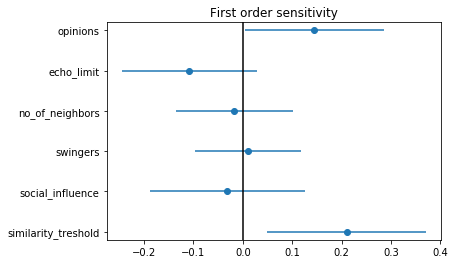

TypeError: must be str, not ResultDict

In [23]:
for Si in to_plot:
    # First order
    plot_index(Si, problem['names'], '1', 'First order sensitivity')
    plt.show()
    plt.savefig('./img/'+Si +'_firstOrder.png')


#     # Second order
#     plot_index(Si, problem['names'], '2', 'Second order sensitivity')
#     plt.show()

    # Total order
    plot_index(Si, problem['names'], 'T', 'Total order sensitivity')
    plt.show()
    plt.savefig('./img/'+Si +'_TotalOrder.png')